# Imports

In [1]:
import pathlib

import numpy as np
import pandas as pd
from glob import glob

from obspy import read, UTCDateTime
from obspy.geodetics import gps2dist_azimuth

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.offsetbox import AnchoredText


import seaborn as sns

In [2]:
plt.style.use("../../qm_manuscript.mplstyle")
plt.rcParams.update({"font.family": "Helvetica"})

# Read in catalogue

In [3]:
# Read in events
events_df = pd.DataFrame()
for f in sorted(glob("./generate_results/outputs/runs/24h_run/locate/events/*event")):
    try:
        events_df = events_df.append(pd.read_csv(f))
    except EmptyDataError:
        pass
    events_df = events_df.reset_index(drop=True)
events_df

events_df.loc[:, "DT"] = pd.to_datetime(events_df.DT).dt.tz_convert(None)
events_df

,EventID,DT,X,Y,Z,COA,COA_NORM,GAU_X,GAU_Y,GAU_Z,...,GAU_ErrZ,COV_ErrX,COV_ErrY,COV_ErrZ,TRIG_COA,DEC_COA,DEC_COA_NORM,ML,ML_Err,ML_r2
0,20111026002402300,2011-10-26 00:24:02.000,-16.431824,65.138572,5.0,3.521,1.761,-16.416891,65.138830,5.573,...,5.385,6.688,6.846,4.806,1.310,2.551,1.310,-0.49100,0.173,0.0124
1,20111026034548000,2011-10-26 03:45:47.800,-16.634203,65.101889,20.0,3.511,1.719,-16.612571,65.095596,20.767,...,2.752,8.739,8.234,7.188,1.339,2.639,1.339,0.07960,0.227,-1.4200
2,20111026052643920,2011-10-26 05:26:43.760,-16.284385,65.173314,3.6,10.230,5.008,-16.285187,65.170641,4.481,...,3.696,1.142,1.080,1.694,1.670,3.271,1.670,0.40300,0.302,0.7110
3,20111026063741040,2011-10-26 06:37:40.840,-16.385171,65.110708,3.2,10.160,5.045,-16.377111,65.107506,4.535,...,3.022,1.121,1.151,1.629,1.573,3.053,1.573,0.35300,0.264,0.6720
4,20111026070114180,2011-10-26 07:01:13.980,-16.655308,65.018469,2.7,4.274,2.148,-16.652823,65.016297,3.423,...,3.602,2.712,2.760,3.105,1.346,2.610,1.346,-0.10800,0.260,0.7330
5,20111026071047080,2011-10-26 07:10:46.820,-16.251378,65.087136,5.1,5.405,2.699,-16.287016,65.091286,5.621,...,3.706,3.309,3.295,3.817,1.500,2.914,1.500,0.04660,0.218,0.4500
6,20111026080224840,2011-10-26 08:02:24.660,-16.383050,65.109808,3.2,6.122,3.055,-16.383543,65.103983,4.418,...,3.255,2.022,2.496,2.573,1.468,2.850,1.468,0.11400,0.272,0.3640
7,20111026085210780,2011-10-26 08:52:10.660,-16.370503,65.083779,3.1,3.864,1.937,-16.374995,65.095324,4.026,...,3.492,4.164,4.630,3.996,1.329,2.585,1.329,-0.33300,0.254,0.2720
8,20111026092058320,2011-10-26 09:20:58.200,-16.257123,65.136480,3.9,3.721,1.869,-16.252650,65.139350,4.928,...,4.148,11.273,10.590,6.695,1.323,2.573,1.323,-0.26500,0.276,-0.9880
9,20111026092255800,2011-10-26 09:22:55.820,-16.259266,65.135588,3.7,3.955,1.983,-16.259531,65.126396,5.347,...,4.505,6.003,7.856,5.110,1.311,2.552,1.311,-0.27500,0.277,-0.4930


# Functions

In [4]:
def get_aspect(xmin, xmax, ymin, ymax, zmin, zmax, scale=1000):
    """
    Get aspect ratios for map, lat XS & lon XS for given coords.
    
    Assumes cross-section depths are in KILOMETRES.
    
    """
    
    map_ns_metres, _, _ = gps2dist_azimuth(ymin, xmin, ymax, xmin)
    map_ns_deg = ymax - ymin
    map_ew_metres, _, _ = gps2dist_azimuth(ymin, xmin, ymin, xmax)
    map_ew_deg = xmax - xmin
    
    map_aspect = (map_ns_metres / map_ns_deg) / (map_ew_metres / map_ew_deg)
    
    lat_aspect = (map_ns_metres / scale) / map_ns_deg
    lon_aspect = map_ew_deg / (map_ew_metres / scale)
    
    lon_xs_height_ratio = [(ymax - ymin), (zmax - zmin) / lat_aspect]
    lat_xs_width_ratio = [(xmax - xmin), (zmax - zmin) * lon_aspect]
    
    map_lon_fig_ratio = sum(lon_xs_height_ratio) * map_aspect / (xmax - xmin)
    
    map_lat_fig_ratio = (ymax - ymin) / sum(lat_xs_width_ratio) * map_aspect
    
    
    return (map_aspect, lat_aspect, lon_aspect, lat_xs_width_ratio, lon_xs_height_ratio,
            map_lon_fig_ratio, map_lat_fig_ratio)


def get_scalebar_deg(dist, xmin, xmax, ymin, ymax):
    """Get length of scalebar for given x-axis scaling."""
    
    y_mean = np.mean([ymin, ymax])
    
    map_ew_metres, _, _ = gps2dist_azimuth(y_mean, xmin, y_mean, xmax)
    map_ew_deg = xmax - xmin

    deg = dist * 1000 / (map_ew_metres / map_ew_deg)
    
    return deg

# XY files

In [5]:
# Cross-section topography
topo_bedrock_ns = pd.read_csv("./XY_FILES/topo_section_lat_vadalda.xygt",
                              sep="\s+", comment="#",
                              names=["X", "Y", "d", "Z"])

# Askja calderas
askja_calderas = []
for f in sorted(glob("./XY_FILES/askjacalderas_*.csv")):
    askja_calderas.append(pd.read_csv(f, comment="#",
                                      names=["X", "Y"]))

# Glaciers
glaciers = []
for f in sorted(glob("./XY_FILES/big_glaciers/*.csv")):
    glaciers.append(pd.read_csv(f, comment="#",
                                names=["X", "Y"]))

# Central volcanoes
central_volc = []
for f in sorted(glob("./XY_FILES/centralvolc/*.csv")):
    central_volc.append(pd.read_csv(f, comment="#",
                                    names=["X", "Y"]))

# Fissure swarms
fiss_swarms = []
for f in sorted(glob("./XY_FILES/fisswarms/*.csv")):
    fiss_swarms.append(pd.read_csv(f, comment="#",
                                   names=["X", "Y"]))


# Station coordinates
stations = pd.read_csv("./generate_results/inputs/askja_stations.txt")

# Iceland coastline
iceland = pd.read_csv("./XY_FILES/iceland_outline.xy",
                      sep=" ", names=["X", "Y"])

# Plot Figure 9

<ipython-input-6-90428ed8cd01>:436: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


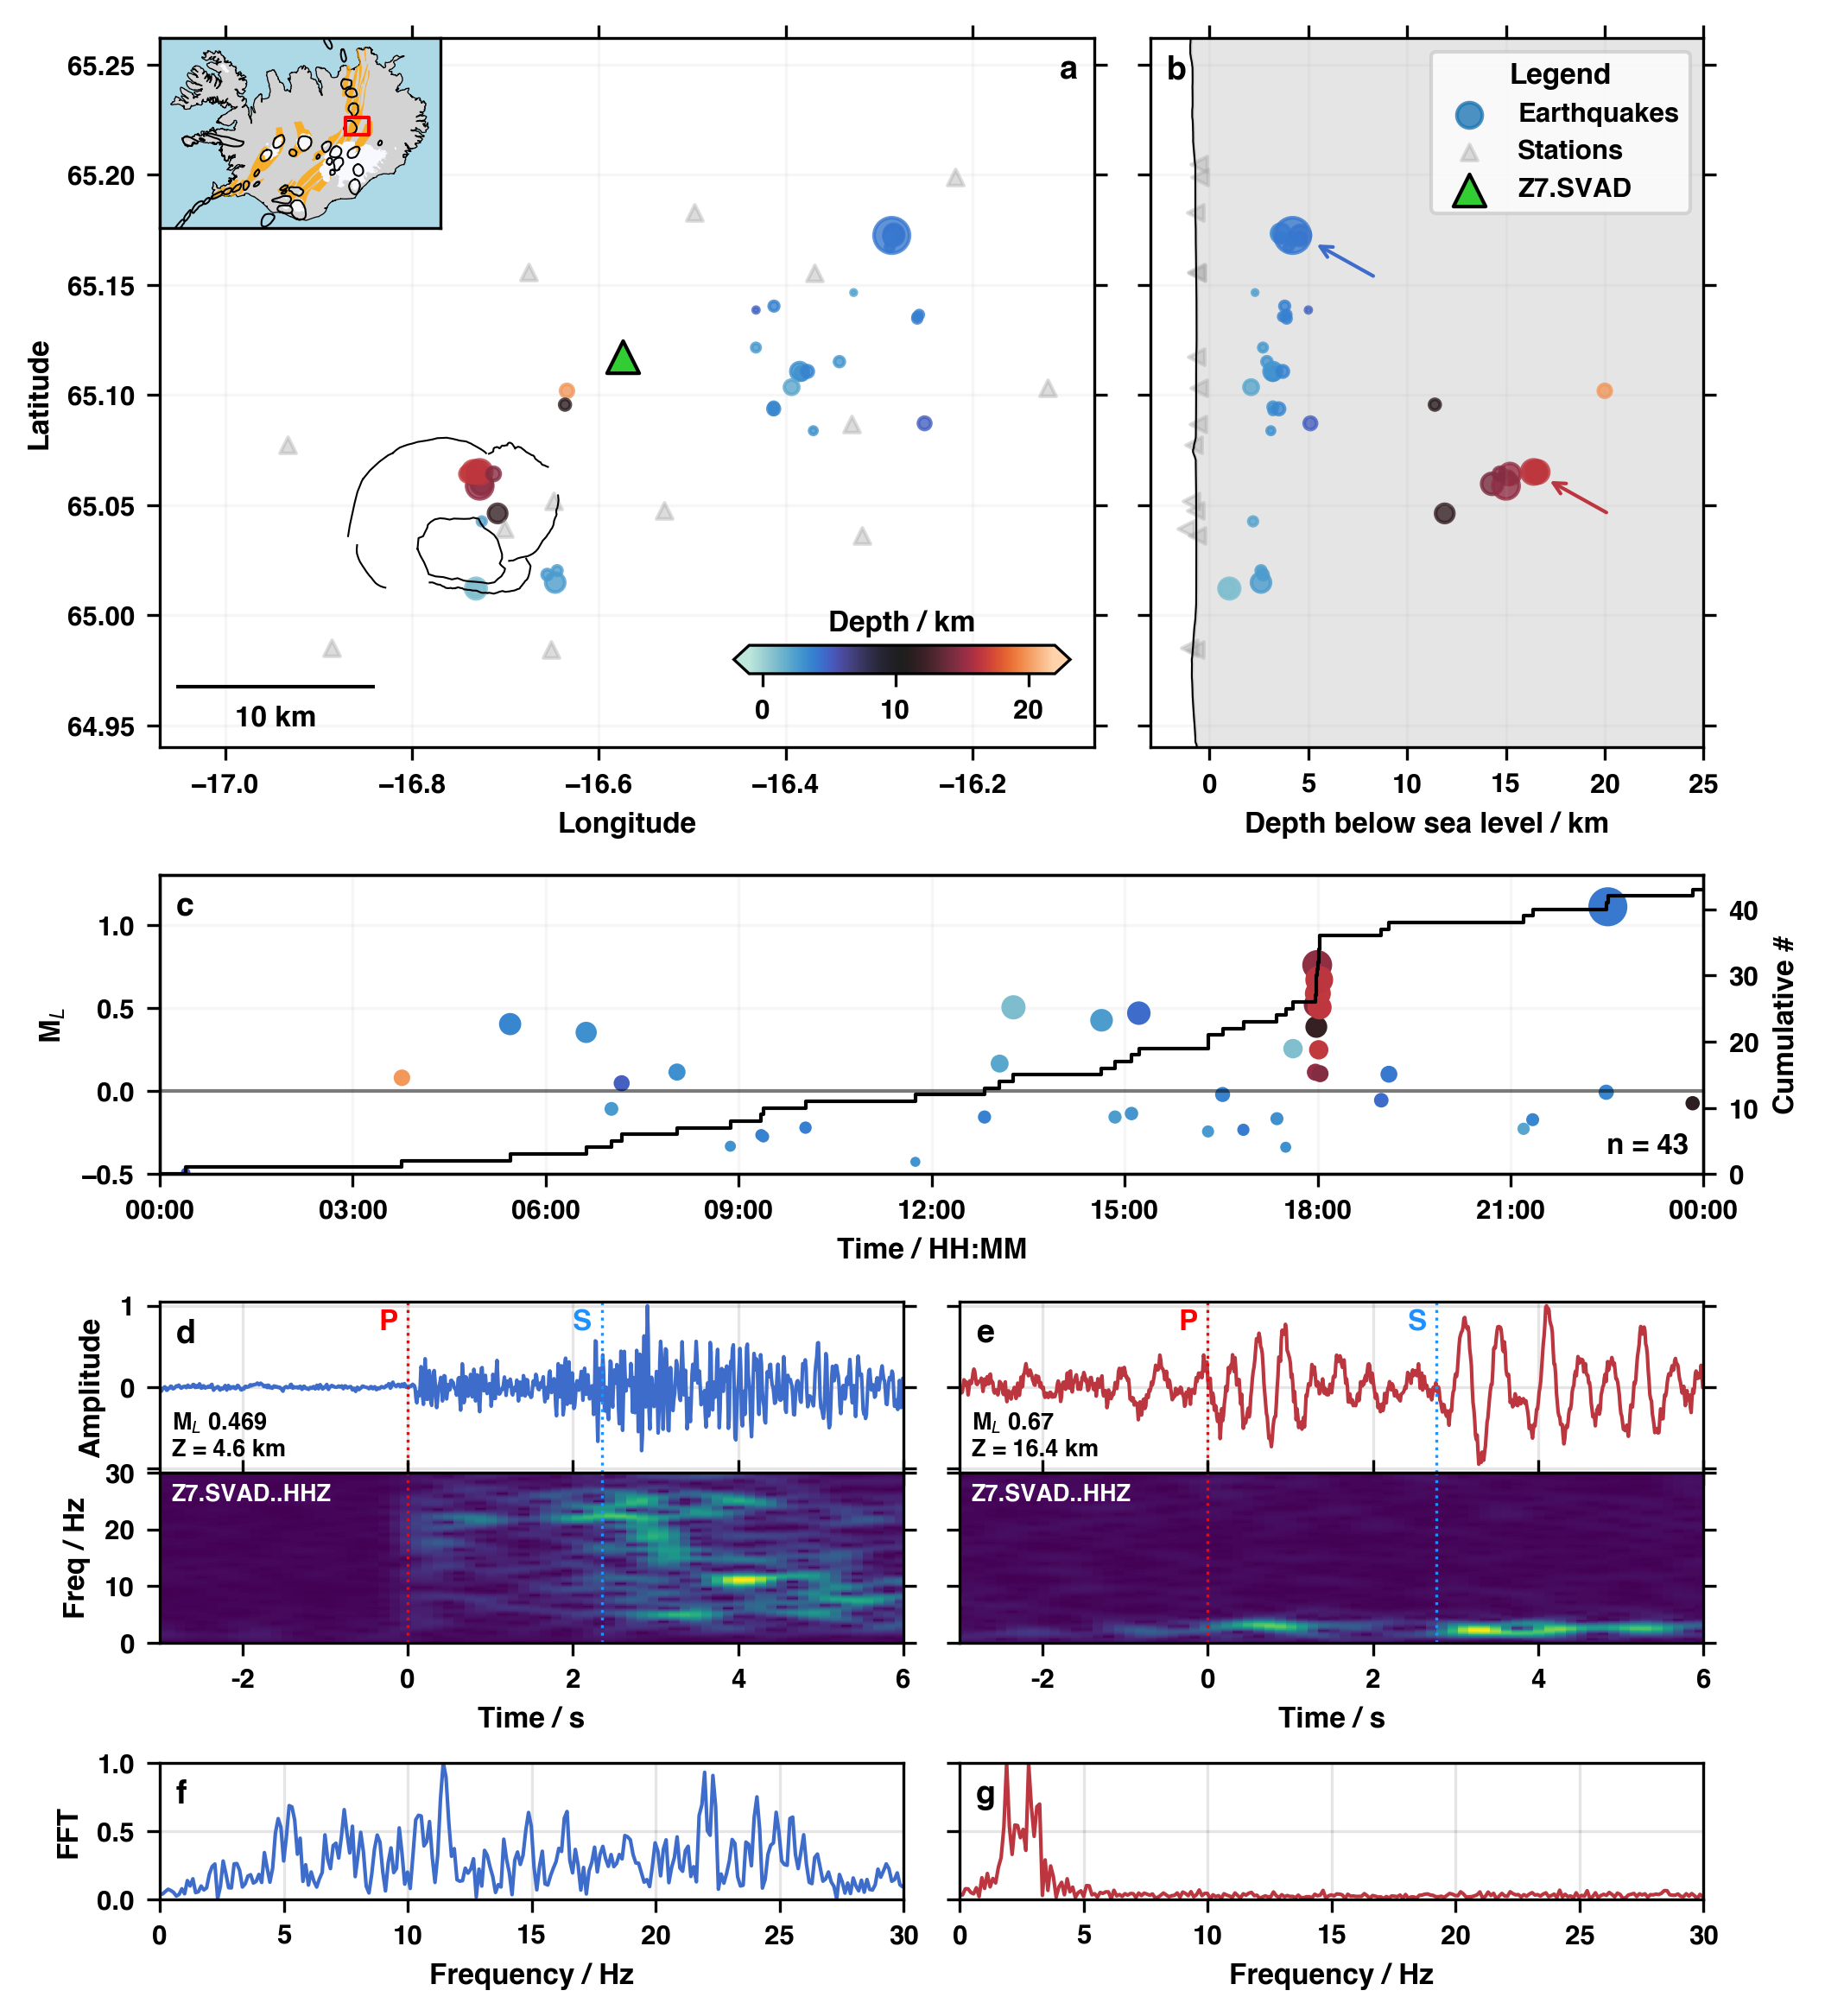

In [6]:
## Prep
plt.rcParams.update({
    'font.size': 8,
    'xtick.labelsize': 7.5,
    'ytick.labelsize': 7.5,
    'legend.fontsize': 7.5,
    'axes.labelsize': 8,
    'axes.titlesize': 7,
    'date.autoformatter.hour': '%H:%M'
})

# Make copy of input data
df = events_df.copy().sort_values(by="DT").reset_index(drop=True)

# Set plot extent
xmin = -17.07 
xmax = -16.07
ymin = 64.94
ymax = 65.262
zmin = -3
zmax = 25

# Get aspect ratios
map_aspect, lat_aspect, lon_aspect, lat_xs_width_ratio, lon_xs_height_ratio, \
    map_lon_fig_ratio, map_lat_fig_ratio = get_aspect(xmin, xmax, ymin, ymax, zmin, zmax)

# Set height ratio for time axes
time_ax_height = 0.4

# Set height ratio for waveform / spectrogram axes
spec_ax_height = 0.8

# Setup figure
fig_width = 180 / 25.4  # Seismica full-width = 180; half-width = 86 mm
fig_height = map_lat_fig_ratio * fig_width * (1 + time_ax_height + spec_ax_height + 0.15)

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300, facecolor="w")

# GridSpec
gs = GridSpec(nrows=3, ncols=2,
              width_ratios=lat_xs_width_ratio,
              height_ratios=[1, time_ax_height, spec_ax_height])

# gridspec -- outer
spec_gs = GridSpecFromSubplotSpec(nrows=2, ncols=2,
                                  height_ratios=[2, 0.8], width_ratios=[1, 1],
                                  subplot_spec=gs[2, :], hspace=0.5)
# gridspec 1 -- within top subplot
gs1 = GridSpecFromSubplotSpec(nrows=2, ncols=2,
                              height_ratios=[1, 1], width_ratios=[1, 1],
                              subplot_spec=spec_gs[0, :],
                              hspace=0)

# Setup axes
ax_map = fig.add_subplot(gs[0, 0], aspect=map_aspect, adjustable="box", anchor="SE")
ax_xs = fig.add_subplot(gs[0, 1], aspect=lat_aspect, adjustable="box", anchor="SW",
                        sharey=ax_map)
ax_time = fig.add_subplot(gs[1, :], anchor="N")


## Plotting

# What to colour by
c = "Z"
vmin = -1
vmax = 22
alpha = 0.8
cmap = sns.color_palette("icefire", as_cmap=True)

cmap_sm = plt.cm.ScalarMappable(cmap=cmap,
                                norm=plt.Normalize(vmin, vmax))


# Plot map
cmpble = ax_map.scatter(df.X, df.Y, c=df[c], cmap=cmap, alpha=alpha,
                        vmin=vmin, vmax=vmax, s=((df.ML+2)**5)/3,
                        label="Earthquakes")
# Grid
ax_map.grid("k", alpha=0.1)

# Askja nested calderas
for xy_df in askja_calderas:
    ax_map.plot(xy_df.X, xy_df.Y,
                ls="-", lw=0.5, c="k")

# Stations
ax_map.scatter(stations.Longitude, stations.Latitude,
               marker="^", s=20, alpha=0.4,
               color="darkgrey", edgecolors="darkgrey", label="Stations")
ax_map.scatter(stations.query("Name == 'SVAD'").Longitude,
               stations.query("Name == 'SVAD'").Latitude,
               marker="^", s=80,
               color="limegreen", edgecolors="k", label="Z7.SVAD")

# scalebar
scalebar_len = 10  # Length in kilometres
scalebar = AnchoredSizeBar(ax_map.transData,
                           size=get_scalebar_deg(scalebar_len,
                                                 xmin, xmax,
                                                 ymin, ymax),
                           label=f"{scalebar_len} km",
                           loc="lower left", pad=0.5, sep=5,
                           frameon=False, color="k")
ax_map.add_artist(scalebar)    


# Colorbar
cax = inset_axes(ax_map, width="90%", height="10%",
                 bbox_to_anchor=(0.6, 0.085, 0.4, 0.4),
                 bbox_transform=ax_map.transAxes, loc="lower left")
fig.colorbar(cmap_sm, cax=cax, orientation="horizontal", extend='both')
cax.set_xlabel("Depth / km")
cax.xaxis.set_label_position("top")


# Set axes limits & labels
ax_map.set_xlim(xmin, xmax)
ax_map.set_ylim(ymin, ymax)
ax_map.set_ylabel("Latitude")
ax_map.set_xlabel("Longitude")
ax_map.tick_params(which="both", bottom=True, top=True, right=True,
                   labelbottom=True)

# Add label
ax_map.add_artist(AnchoredText("a", loc="upper right",
                  prop={"size": 9, "weight": "bold"},
                  frameon=False, borderpad=0.1))


## Plot inset map
inset_xmin = -25
inset_xmax = -13
inset_ymin = 63.25
inset_ymax =66.7

# Get aspect ratios & make axes
inset_aspect, *_ = get_aspect(xmin, xmax, ymin, ymax, 0, 0)

ax_inset = inset_axes(ax_map, width="30%", height="30%",
                      bbox_transform=ax_map.transAxes,
                      bbox_to_anchor=(0, 0, 1, 1),
                      loc="upper left",
                      axes_kwargs={
                          "anchor": "NW",
                          "aspect": inset_aspect,
                          "facecolor": "lightblue"
                          },
                      borderpad=0)

# Iceland landmass
ax_inset.fill(iceland.X, iceland.Y, facecolor="lightgrey",
              linewidth=0.3, linestyle="-", edgecolor="k")
# Fissure swarms
for xy_df in fiss_swarms:
    ax_inset.fill(xy_df.X, xy_df.Y, facecolor="orange", alpha=0.8)
# Glaciers
for xy_df in glaciers:
    ax_inset.fill(xy_df.X, xy_df.Y, facecolor="ghostwhite")
# Central volcanoes
for xy_df in central_volc:
    ax_inset.plot(xy_df.X, xy_df.Y, ls="-", lw=0.5, c="k")

# Outline of zoom map
ax_inset.plot([xmin, xmin, xmax, xmax, xmin],
              [ymin, ymax, ymax, ymin, ymin],
              c="r", lw=1, zorder=10)

# Tick & axes params
ax_inset.tick_params(left=False, bottom=False,
                     labelleft=False, labelbottom=False)
ax_inset.set_xlim(inset_xmin, inset_xmax)
ax_inset.set_ylim(inset_ymin, inset_ymax)


## Plot cross-section
ax_xs.scatter(df.Z, df.Y, c=df[c], cmap=cmap, alpha=alpha,
              vmin=vmin, vmax=vmax, s=((df.ML+2)**5)/3)
# Grid
ax_xs.grid("k", alpha=0.1)

# Stations
ax_xs.scatter(-stations.query("@xmin < Longitude < @xmax").Elevation,
              stations.query("@xmin < Longitude < @xmax").Latitude,
              marker="<", s=20, alpha=0.4,
              color="darkgrey", edgecolors="darkgrey")
# Topography
ax_xs.plot(topo_bedrock_ns.Z/-1000, topo_bedrock_ns.Y, c="k", lw=0.5)
ax_xs.fill_betweenx(topo_bedrock_ns.Y, topo_bedrock_ns.Z/-1000, zmax,
                    color="grey", alpha=0.2, zorder=0)

# Set axes limits and labels
ax_xs.set_xlim(zmin, zmax)
ax_xs.set_xlabel("Depth below sea level / km")
ax_xs.set_ylim(ymin, ymax)
ax_xs.tick_params(which="both", left=True, right=True, top=True,
                  labelleft=False, labelright=False)

# Add label
ax_xs.add_artist(AnchoredText("b", loc="upper left",
                 prop={"size": 9, "weight": "bold"},
                 frameon=False, borderpad=0.1))


## Legend
handles, labels = ax_map.get_legend_handles_labels()
handles_2, labels_2 = ax_xs.get_legend_handles_labels()
handles.extend(handles_2)
labels.extend(labels_2)

leg = ax_xs.legend(handles, labels, loc="upper right")
leg.set_title("Legend", prop={"weight": "bold"})


## Plot Timeline
ax_time.scatter(df.DT, df.ML, c=df[c], cmap=cmap, vmin=vmin, vmax=vmax,
                alpha=alpha*1.5, s=((df.ML+2)**5)/3, zorder=2)
# Grid
ax_time.grid("k", alpha=0.1)

# Set axes labels and limits
ax_time.set_ylabel("M$_L$")
ax_time.set_ylim(-0.5, 1.3)
ax_time.set_xlabel("Time / HH:MM")
ax_time.axhline(0, c="k", lw=1, alpha=0.5)
ax_time.set_xlim(UTCDateTime("2011-299T00:00:00").datetime,
                 UTCDateTime("2011-300T00:00:00").datetime)

# Add # of earthquakes
ax_time.add_artist(AnchoredText(f"n = {len(df)}", loc="lower right",
                   borderpad=0.1, frameon=False))
# Add label
ax_time.add_artist(AnchoredText("c", loc="upper left",
                   prop={"size": 9, "weight": "bold"},
                   frameon=False, borderpad=0.1))

# Plot cumulative # of events
ax_count = ax_time.twinx()
# Extend to continue to end of plot
ax_count.step(np.concatenate(([np.datetime64(UTCDateTime("2011-299").datetime)],
                              df.DT.values,
                              [np.datetime64(UTCDateTime("2011-300").datetime)])),
              np.concatenate(([0], df.index.values+1, [df.index[-1]+1])),
              c="k", lw=1, where="post")

# Set axes labels, limits
ax_count.set_ylabel("Cumulative #")
ax_count.set_ylim(bottom=0)

fig.autofmt_xdate(rotation=0, ha="center")


### Waveform & spectrogram plots 

qm_out = pathlib.Path("./generate_results/outputs/runs/24h_run/locate")
archive = pathlib.Path("./generate_results/inputs/mSEED")

station = "SVAD"
comp = "Z"
phase = "P"

filt1 = 1.5
filt2 = 30.0  # 60.0
bandpass = True
lowpass = False

pre_time = 3
post_time = 6

FFTs = []
frqs = []

labels = [["d", "f"], ["e", "g"]]

for i, event_id in enumerate(["20111026151312040", "20111026180130100"]):
    
    pickfile = qm_out / "picks" / f"{event_id}.picks"
    eventfile = qm_out / "events" / f"{event_id}.event"
    picks = pd.read_csv(pickfile)
    event = pd.read_csv(eventfile)
    origin_time = UTCDateTime(event.loc[0, "DT"])
    file = (archive / f"{origin_time.year}" / f"{origin_time.julday:03d}" /
            f"{station}_{comp}.m").as_posix()
    st = read(file, starttime=origin_time-20, endtime=origin_time+60)
    
    pickline = picks.query("Station == @station and Phase == @phase").iloc[0]
    if pickline.PickTime == "-1":
        pick = UTCDateTime(pickline.ModelledTime)
    else:
        pick = UTCDateTime(pickline.PickTime)
        
    s_pickline = picks.query("Station == @station and Phase == 'S'").iloc[0]
    if s_pickline.PickTime == "-1":
        s_pick = UTCDateTime(s_pickline.ModelledTime)
    else:
        s_pick = UTCDateTime(s_pickline.PickTime)
        
    s_p_time = s_pick - pick

    if len(st) != 1:
        print("Uh oh")
        print(st)
        break
    elif st[0].stats.starttime > pick or st[0].stats.endtime < pick:
        print("Uh oh - no waveform data at time of pick!")
        print(st)
        break

    tr = st[0]

    tr.detrend('demean')
    tr.taper(0.05, "cosine")

    #print "Filtering.."
    if bandpass:
        tr.filter("bandpass", freqmin=filt1, freqmax=filt2,
                corners=2, zerophase=True)
    if lowpass:
        tr.filter("lowpass", freq=filt2,
                corners=2, zerophase=True)

    tr_spec = tr.copy().trim(starttime=pick-2*pre_time,
                             endtime=pick+2*post_time)
    tr.trim(starttime=pick-pre_time,
            endtime=pick+post_time)

    sps = tr.stats.sampling_rate
    s_int = 1.0 / sps  #sampling interval
    t = np.arange(0, 1, s_int)  #time vector

    n = tr.stats.npts
    k = np.arange(n)
    secs = (k / sps) # for the axis
    T = n / sps
    frq = k / T  # +ve/-ve frequency range
    frq = frq[range(n // 2)]  # just +ve freqency range

    #print "Computing fourier transform..."
    try:
        FFT = np.fft.fft(tr.data) / n  # /n to normalise, since length of trace is max possible frequency
        FFT = abs(FFT[range(n // 2)])  # taking only the +ve half of FFT
        FFT = FFT / np.amax(FFT)  # normalising
    except:
        continue
        
    FFTs.append(FFT)
    frqs.append(frq)
    
    
    
    ## PLOTTING
    
    # Add arrow to event on ax_xs
    z = event.Z.values[0]
    y = event.Y.values[0]
    ax_xs.annotate("", xy=(z+0.5, y-0.0025), xytext=(z+4, y-0.02),
            arrowprops=dict(arrowstyle="->", color=cmap_sm.to_rgba(z)))
    
    ax1 = plt.subplot(gs1[0, i])
    ax2 = plt.subplot(gs1[1, i], sharex=ax1)
    ax3 = plt.subplot(spec_gs[1, i])

    
    # Plot trace
    ax1.plot(secs+pre_time, tr.data / tr.max(),
             color=cmap_sm.to_rgba(event.Z.values[0]), lw=1)
    # Plot picks
    ax1.axvline(2*pre_time, ls=":", c="r")
    ax1.axvline(2*pre_time+s_p_time, ls=":", c="dodgerblue")
    ax1.text(pre_time*2-0.35, 0.7, "P",
             transform=ax1.transData,
             fontsize=8, color="r")
    ax1.text(2*pre_time+s_p_time-0.35, 0.7, "S",
             transform=ax1.transData,
             fontsize=8, color="dodgerblue")
    # Set axes labels / limits
    if i == 0:
        ax1.set_ylabel('Amplitude')
    else:
        ax1.tick_params(labelleft=False)
    ax1.tick_params(right=True,
                    labelbottom=False)
    ax1.set_yticks([-1, 0, 1])
    ax1.set_yticklabels(["", "0", "1"])
    ax1.set_ylim(-1.05, 1.05)
    ax1.grid(c="k", alpha=0.1)
    # Annotate with event stats
    ax1.add_artist(AnchoredText(f"{labels[i][0]}",
                                loc="upper left",
                                prop={"size": 9, "weight": "bold"},
                                frameon=False, borderpad=0.1))
    ax1.add_artist(AnchoredText((f"M$_L$ {event.ML.values[0]}\n"
                                 f"Z = {event.Z.values[0]} km"),
                                loc="lower left", prop={"size": 6.5},
                                frameon=False, borderpad=0.1))

    # Plot spectrogram
    tr_spec.spectrogram(axes=ax2)
    # Plot picks
    ax2.axvline(pre_time*2, ls=":", c="r")
    ax2.axvline(pre_time*2+s_p_time, ls=":", c="dodgerblue")
    # Set axes limits & labels
    ax2.set_xlim(xmin=pre_time, xmax=2*pre_time+post_time)
    ax2.set_ylim(0, filt2)
    if i == 0:
        ax2.set_ylabel('Freq / Hz')
    else:
        ax2.tick_params(labelleft=False)
    ax2.tick_params(right=True, top=True)
    ax2.set_xlabel('Time / s')
    ax2.set_xticks(np.arange(2*pre_time-2, 2*pre_time+post_time+1, 2))
    ax2.set_xticklabels(np.arange(-2, 7, 2))
    # Annotate with Trace ID
    ax2.add_artist(AnchoredText(tr_spec.id,
                                loc="upper left",
                                frameon=False, borderpad=0.1,
                                prop={"color": "w", "size": 6.5}))
    
    # Plot FFT
    ax3.plot(frq, FFT / np.max(FFT),
             color=cmap_sm.to_rgba(event.Z.values[0]), lw=1)

    # Axes labels, limits
    ax3.set_xlabel('Frequency / Hz')
    if i == 0:
        ax3.set_ylabel('FFT')
    else:
        ax3.tick_params(labelleft=False)
    ax3.set_xlim(0, filt2)
    ax3.set_ylim(0, 1)
    ax3.grid(c="k", alpha=0.1)
    ax3.add_artist(AnchoredText(f"{labels[i][1]}",
                                loc="upper left",
                                prop={"size": 9, "weight": "bold"},
                                frameon=False, borderpad=0.1))

fig.tight_layout()